In [1]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
import tensorflow as tf
from nltk.corpus import stopwords
import requests
import os
import re
import tensorflow
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import urllib.request
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.9.1
2.17.1
2.2.2


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
74281,Scientists reveal why whisky tastes better wit...,Sweden-based chemists have revealed adding wat...
81058,Uttarakhand witnessed maximum number of protes...,Uttarakhand had witnessed the maximum number o...
46211,Dravid's prize money cut to Ã¢ÂÂ¹25L after he...,BCCI has accepted India Under-19 head coach Ra...
38321,Mozilla working on a voice-controlled web brow...,Firefox web browser maker Mozilla is reportedl...
28345,Mexico fans lift Korean ambassador as S Korea ...,Hundreds of Mexican fans arrived at the South ...
57431,US' Jerusalem decision challenge to Muslim wor...,US President Donald Trump's decision to recogn...
66267,Climate change probably doing good: Former Aus...,Former Australian Prime Minister Tony Abbott h...
13359,Put Patel's order banning RSS on his statue: C...,Congress leader Anand Sharma on Monday said th...
68483,"SRK, Mithali Raj, Nita Ambani feature on Vogue...","Shah Rukh Khan, women's cricket team captain M..."
20136,I stand with the person being bullied: Rahul G...,"Claiming the Congress is ""biased"" towards the ..."


### 데이터 전처리하기(추상적 요약)

In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
data.isnull().sum()

,0
headlines,0
text,0


In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# # 데이터 전처리 함수
# def preprocess_sentence(sentence, remove_stopwords=True):
#     sentence = sentence.lower() # 텍스트 소문자화
#     sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
#     sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
#     sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
#     sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
#     sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
#     sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

#     # 불용어 제거 (Text)
#     if remove_stopwords:
#         tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
#     # 불용어 미제거 (Summary)
#     else:
#         tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
#     return tokens

In [10]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text  # HTML 문법 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호 안에 문자열 제거
    sentence = re.sub('"', '', sentence)  # 쌍따옴표 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자 제거
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # m이 3개 이상이면 2개로 변경
    sentence = re.sub('\s+', ' ', sentence).strip()  # 연속된 공백 제거
    sentence = ' '.join([word for word in sentence.split() if len(word) <= 20])  # 단어 길이 제한
    sentence = re.sub(r'\b(\w+)( \1\b)+', r'\1', sentence)  # 중복 단어 제거
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

* EX)

In [11]:
temp_text = 'Everything I bought was great, infact<I> <ordered twice and the third ordered was<br />for my mother and father.. Father. fffffffffffffffffffffffff'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))

text:  everything bought great infact mother father
summary: great way to start the day


In [12]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

# [[YOUR CODE]]

clean_text = data['text'].apply(lambda x: preprocess_sentence(x) if pd.notnull(x) else "")


# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object


In [13]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_headlines = []

# [[YOUR CODE]]

clean_headlines = data['headlines'].apply(lambda x: preprocess_sentence(x,remove_stopwords=False) if pd.notnull(x) else "")
print("headlines 전처리 후 결과: ", clean_headlines[:5])

<ipython-input-10-3991e79c3a63>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text  # HTML 문법 제거


headlines 전처리 후 결과:  0    upgrad learner switches to career in ml al wit...
1    delhi techie wins free food from swiggy for on...
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4    have known hirani for yrs what if metoo claims...
Name: headlines, dtype: object


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
제목의 최소 길이 : 1
제목의 최대 길이 : 18
제목의 평균 길이 : 9.553660024400163


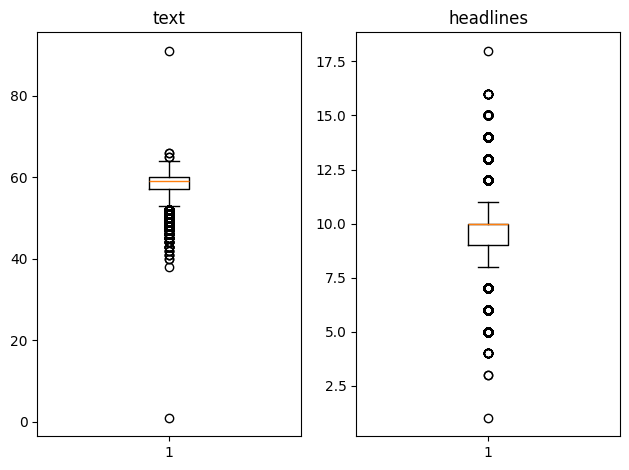

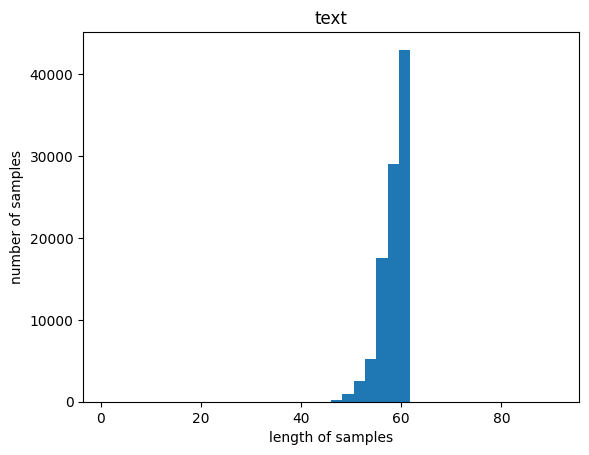

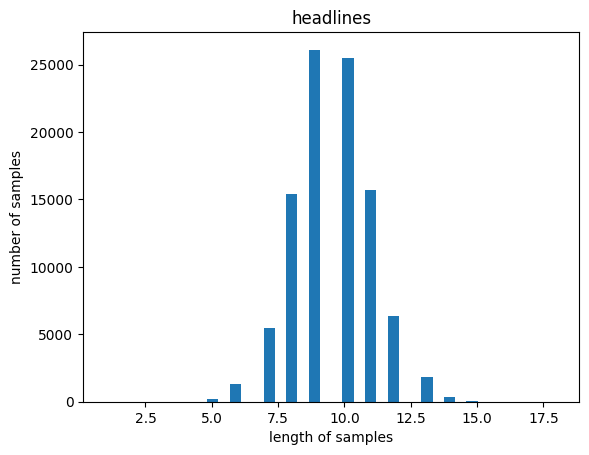

In [14]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('제목의 최소 길이 : {}'.format(np.min(summary_len)))
print('제목의 최대 길이 : {}'.format(np.max(summary_len)))
print('제목의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [16]:
data.isnull().sum()

,0
headlines,0
text,0


In [17]:
text_max_len = 50
summary_max_len = 12

In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9881150874339162


In [20]:
# 굳이 할 필요 없을 것 같긴한데...
# text 열에서 단어 시퀀스 길이 제한
data['text'] = data['text'].apply(lambda s: ' '.join(s.split()[:text_max_len]) if pd.notnull(s) else s)

# headlines 열에서 단어 시퀀스 길이 제한
data['headlines'] = data['headlines'].apply(lambda s: ' '.join(s.split()[:summary_max_len]) if pd.notnull(s) else s)

In [21]:
# 제목에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [23]:
# 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[98250  6304 16650 ... 89216 89112 63442]


In [24]:
# 동일하게
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
src_tokenizer = Tokenizer(oov_token='<UNK>') # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input) # 입력된 데이터로부터 단어 집합 생성

In [26]:
threshold = 6
total_cnt = len(src_tokenizer.word_index)  # 단어 집합 크기
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어 개수
total_freq = 0  # 전체 단어 빈도수 총합
rare_freq = 0  # 희귀 단어 빈도수 총합

# 전체 문서 수 (예: 샘플 수)
total_documents = len(encoder_input)
# 결과 저장용 리스트
freq_inverse_freq_data = []

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    # 전체 빈도수 합계
    total_freq += value

    # 희귀 단어 체크
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

    # 빈도-역빈도 계산 (TF와 IDF 추가)
    tf = value / total_freq  # Term Frequency (TF)
    idf = math.log((total_documents + 1) / (value + 1))  # Inverse Document Frequency (IDF)
    tf_idf = tf * idf  # TF-IDF 계산

    # 빈도, 역빈도, TF-IDF 데이터 저장
    inverse_frequency = 1 / value
    freq_inverse_ratio = value * inverse_frequency
    freq_inverse_freq_data.append((key, value, inverse_frequency, freq_inverse_ratio, tf, idf, tf_idf))

# 결과 출력
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : %s' % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq) * 100)

# 빈도-역빈도 데이터프레임 생성
import pandas as pd
freq_df = pd.DataFrame(freq_inverse_freq_data, columns=[
    "word", "frequency", "inverse_frequency", "freq_inverse_ratio", "TF", "IDF", "TF-IDF"
])

# 상위 몇 개 단어를 출력
print(freq_df.head())

단어 집합(vocabulary)의 크기 : 76278
등장 빈도가 5번 이하인 희귀 단어의 수: 49768
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : 26510
단어 집합에서 희귀 단어의 비율 : 65.24554917538478
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 2.689576175439949
       word  frequency  inverse_frequency  freq_inverse_ratio        TF  \
0   chinese       1755           0.000570                 1.0  1.000000   
1  internet        721           0.001387                 1.0  0.291195   
2     major       1232           0.000812                 1.0  0.332255   
3     baidu         36           0.027778                 1.0  0.009615   
4     fired        610           0.001639                 1.0  0.140101   

        IDF    TF-IDF  
0  4.025606  4.025606  
1  4.914375  1.431044  
2  4.379194  1.455007  
3  7.885482  0.075822  
4  5.081303  0.711896  


##### **1차 시도에선 데이터셋을 분리시키고 단어집합을 만들었다.**
  * 예측 값들이 UNK로 난무하더라.

##### **2차 시도에선 분리 전에 데이터셋을 만들었으나 디코더에서 input만을 활용하는 바람에 eostoken이 학습에 쓰이질 못 했다.**
  * eostoken이 자꾸 없다고 오류가 나는데 머리가 과열되어서 decoder input이랑 decoder tarket에 차이점을 잡아내지 못 했다.

##### **3차 시도에서야 아래와 같은 코드를 추가해서 조정하였다.**
  * ...젠장

In [27]:
data['decoder_conbined'] = data['headlines'].apply(lambda x : 'sostoken '+ x + ' eostoken')
decoder_conbined = np.array(data['decoder_conbined'])
decoder_conbined = decoder_conbined[indices]

In [28]:
tar_tokenizer = Tokenizer(oov_token='<UNK>')
tar_tokenizer.fit_on_texts(decoder_conbined)

In [29]:
data['decoder_conbined']

,decoder_conbined
0,sostoken upgrad learner switches to career in ...
1,sostoken delhi techie wins free food from swig...
2,sostoken new zealand end rohit sharma led indi...
3,sostoken aegon life iterm insurance plan helps...
4,sostoken have known hirani for yrs what if met...
...,...
98396,sostoken crpf jawan axed to death by maoists i...
98397,sostoken first song from sonakshi sinha noor t...
98398,sostoken the matrix film to get reboot reports...
98399,sostoken snoop dogg aims gun at clown dressed ...


In [30]:
data['decoder_conbined'].str.endswith('eostoken').value_counts()

,count
decoder_conbined,
True,98360


###### 빈도, 역빈도, TF-IDF 에서 인사이트 추출을 시도하고 싶었으나 무리 잠이 부족하다.

In [31]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)  # 단어 집합 크기
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어 개수
total_freq = 0  # 전체 단어 빈도수 총합
rare_freq = 0  # 희귀 단어 빈도수 총합

# 전체 문서 수 (예: 샘플 수)
total_documents = len(decoder_conbined)
# 결과 저장용 리스트
freq_inverse_freq_data = []

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    # 전체 빈도수 합계
    total_freq += value

    # 희귀 단어 체크
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

    # 빈도-역빈도 계산 (TF와 IDF 추가)
    tf = value / total_freq  # Term Frequency (TF)
    idf = math.log((total_documents + 1) / (value + 1))  # Inverse Document Frequency (IDF)
    tf_idf = tf * idf  # TF-IDF 계산

    # 빈도, 역빈도, TF-IDF 데이터 저장
    inverse_frequency = 1 / value
    freq_inverse_ratio = value * inverse_frequency
    freq_inverse_freq_data.append((key, value, inverse_frequency, freq_inverse_ratio, tf, idf, tf_idf))

# 결과 출력
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : %s' % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq) * 100)

# 빈도-역빈도 데이터프레임 생성
import pandas as pd
freq_df = pd.DataFrame(freq_inverse_freq_data, columns=[
    "word", "frequency", "inverse_frequency", "freq_inverse_ratio", "TF", "IDF", "TF-IDF"
])

# 상위 몇 개 단어를 출력
print(freq_df.head())

단어 집합(vocabulary)의 크기 : 32528
등장 빈도가 5번 이하인 희귀 단어의 수: 20907
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : 11621
단어 집합에서 희귀 단어의 비율 : 64.2738563698967
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 3.626733371840192
        word  frequency  inverse_frequency  freq_inverse_ratio        TF  \
0   sostoken      98360           0.000010                 1.0  1.000000   
1      china       1332           0.000751                 1.0  0.013361   
2      baidu         13           0.076923                 1.0  0.000130   
3      fires        139           0.007194                 1.0  0.001392   
4  executive         71           0.014085                 1.0  0.000711   

        IDF    TF-IDF  
0  0.000000  0.000000  
1  4.301212  0.057469  
2  8.857342  0.001155  
3  6.554757  0.009125  
4  7.219734  0.005130  


### 하도 당한게 많아서 재차 검증했다. eostoken과 sostoken이 각각 잘 들어가서 빈도 최상에 위치한 것을 확인할 수 있었다.
* 0번과 8번이다.

In [32]:
freq_df['word'].head(15)

,word
0,sostoken
1,china
2,baidu
3,fires
4,executive
5,over
6,ethics
7,violation
8,eostoken
9,kamal


In [33]:
freq_df['frequency'].sort_values()

,frequency
16263,1
22798,1
22797,1
22796,1
22792,1
...,...
85,15328
75,26494
11,31356
8,98360


In [34]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [35]:
# 데이터 분리 전에 집합생성을 했어야!!!
src_vocab = 25000  #  text 단어집합 제한
tar_vocab = 10000   # headlines 단어집합 제한

# 인코더 입력 데이터(text) 기반 어휘 사전 생성
src_tokenizer = Tokenizer(num_words=src_vocab, oov_token='<UNK>')
src_tokenizer.fit_on_texts(encoder_input)

# 디코더 입력/타겟 데이터(headlines) 기반 어휘 사전 생성
tar_tokenizer = Tokenizer(num_words=tar_vocab, oov_token='<UNK>')
tar_tokenizer.fit_on_texts(decoder_conbined)

# 데이터 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 확인
print("훈련 데이터 샘플:", encoder_input_train[:3])
print("훈련 타겟 샘플:", decoder_target_train[:3])
print("디코더 인풋트레인 샘플:", decoder_input_train[:3])
print("디코더 인풋트레인 샘플:", decoder_target_train[:3])
print("테스트 데이터 샘플:", encoder_input_test[:3])
print("테스트 타겟 샘플:", decoder_target_test[:3])

훈련 데이터 샘플: [[276, 868, 457, 9911, 1081, 371, 630, 237, 1, 98, 2698, 2765, 22906, 19484, 1145, 2593, 33, 10998, 55, 33, 22906, 670, 22907, 1896, 1731, 4320, 230, 457, 4622, 13134, 33, 2046, 1659, 9911, 1, 6438, 16584, 782, 297], [5993, 586, 301, 57, 811, 561, 59, 37, 95, 584, 27, 628, 409, 472, 2093, 1299, 4784, 22, 48, 15, 35, 37, 1227, 7194, 502, 57, 17, 174, 132, 105, 289, 22, 48, 15, 9047, 7195, 7, 1333, 166], [9, 5746, 1028, 917, 880, 5898, 2787, 76, 170, 9739, 604, 6678, 1028, 917, 503, 348, 558, 1137, 4, 423, 2940, 5898, 947, 6678, 1, 1, 543, 947, 1028, 917, 880, 5898, 2787, 30, 3773, 406, 367, 558]]
훈련 타겟 샘플: [[59, 7093, 1106, 2085, 16, 8703, 2839, 3], [1612, 2542, 4, 22, 1715, 443, 86, 78, 425, 114, 3], [1801, 1188, 8, 2086, 5611, 4451, 2934, 1, 4, 6017, 3]]
디코더 인풋트레인 샘플: [[2, 59, 7093, 1106, 2085, 16, 8703, 2839], [2, 1612, 2542, 4, 22, 1715, 443, 86, 78, 425, 114], [2, 1801, 1188, 8, 2086, 5611, 4451, 2934, 1, 4, 6017]]
디코더 인풋트레인 샘플: [[59, 7093, 1106, 2085, 16, 8703, 2839, 3]

In [36]:
# eos sos 만 남은거 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [37]:
# 뒤에다가 max_len으로 기준잡고 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [38]:
# 고뇌의 흔적들이다.
UNK_count_train = sum(1 for sentence in encoder_input_train for token in sentence if token == src_tokenizer.word_index['<UNK>'])
UNK_count_test = sum(1 for sentence in encoder_input_test for token in sentence if token == src_tokenizer.word_index['<UNK>'])

print(f"encoder train UNK 비율: {UNK_count_train / sum(len(sentence) for sentence in encoder_input_train):.2%}")
print(f"encoder test UNK 비율: {UNK_count_test / sum(len(sentence) for sentence in encoder_input_test):.2%}")

encoder train UNK 비율: 2.07%
encoder test UNK 비율: 2.09%


In [39]:
# 패딩확이;ㄴ
print("encoder_input_train :", encoder_input_train[:3])
print("decoder_input_train:", decoder_input_train[:3])
print("decoder_target_train:", decoder_target_train[:3])

encoder_input_train : [[  276   868   457  9911  1081   371   630   237     1    98  2698  2765
  22906 19484  1145  2593    33 10998    55    33 22906   670 22907  1896
   1731  4320   230   457  4622 13134    33  2046  1659  9911     1  6438
  16584   782   297     0     0     0     0     0     0     0     0     0
      0     0]
 [ 5993   586   301    57   811   561    59    37    95   584    27   628
    409   472  2093  1299  4784    22    48    15    35    37  1227  7194
    502    57    17   174   132   105   289    22    48    15  9047  7195
      7  1333   166     0     0     0     0     0     0     0     0     0
      0     0]
 [    9  5746  1028   917   880  5898  2787    76   170  9739   604  6678
   1028   917   503   348   558  1137     4   423  2940  5898   947  6678
      1     1   543   947  1028   917   880  5898  2787    30  3773   406
    367   558     0     0     0     0     0     0     0     0     0     0
      0     0]]
decoder_input_train: [[   2   59 7093 1106 2

In [40]:
print("encoder_input_train 중 NaN 확인:", np.isnan(encoder_input_train).any())
print("decoder_input_train 중 NaN 확인:", np.isnan(decoder_input_train).any())
print("decoder_target_train 중 NaN 확인:", np.isnan(decoder_target_train).any())

encoder_input_train 중 NaN 확인: False
decoder_input_train 중 NaN 확인: False
decoder_target_train 중 NaN 확인: False


In [41]:
# 설마 넘냐? -> X
print("인코더 입력 max:", np.max(encoder_input_train))
print("디코더 입력 max:", np.max(decoder_input_train))
print("디코더 타겟 max:", np.max(decoder_target_train))
print("디코더 집합 크기:", len(tar_tokenizer.word_index))

인코더 입력 max: 24999
디코더 입력 max: 9999
디코더 타겟 max: 9999
디코더 집합 크기: 32528


### 어텐션 메커니즘 사용하기(추상적 요약)

### 인코더 & 디코더 트랜스포머

* layer와 텐서 라이브러리가 위 과정 어딘가에서 더럽혀지는 현상이 확인되었다.
* 재정의를 해주니까 에러없이 진행

In [42]:
print(tf)

9.010965443848619e-07


In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
import numpy as np

##### 처음엔 이렇게 거창한 시도를 하려고 했던게 아니다.
##### 에러의 무덤 속에서 오기가 생기다보니 점점 일이 커져버렸다.

In [49]:
# Positional Encoding 위치 임베딩
def positional_encoding(max_position, d_model):
    positions = np.arange(max_position)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_encoding = np.zeros((max_position, d_model))
    pos_encoding[:, 0::2] = np.sin(positions * div_term)
    pos_encoding[:, 1::2] = np.cos(positions * div_term)
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# 패딩 건너뛰는 마스킹이다.
def create_padding_mask(seq):
    return tf.cast(tf.math.equal(seq, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

# 디코더가 전체참조 못하게 하는 마스킹이다.
def create_look_ahead_mask(size):
    return 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

# Scaled Dot Product Attention 벡터 내적으로 스칼라 스코어 계산하는 식
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# MultiHeadAttention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads
        self.wq = Dense(d_model, name="wq_dense")
        self.wk = Dense(d_model, name="wk_dense")
        self.wv = Dense(d_model, name="wv_dense")
        self.dense = Dense(d_model, name="output_dense")

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)
        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        return self.dense(concat_attention)

# Feed-Forward Network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        Dense(dff, activation='relu', name="ffn_dense_1"),
        Dense(d_model, name="ffn_dense_2")
    ])

# Transformer Layer
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, name=None):
        super(TransformerLayer, self).__init__(name=name)
        self.mha = MultiHeadAttention(d_model, num_heads, name=f"multi_head_attention_{name}")
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=1e-6, name=f"layernorm1_{name}")
        self.layernorm2 = LayerNormalization(epsilon=1e-6, name=f"layernorm2_{name}")
        self.dropout1 = Dropout(rate, name=f"dropout1_{name}")
        self.dropout2 = Dropout(rate, name=f"dropout2_{name}")

    def call(self, x, mask=None):
        attn_output = self.mha(x, x, x, mask) # 키값벨류 마스킹
        attn_output = self.dropout1(attn_output) # 
        out1 = self.layernorm1(x + attn_output) # 잔차연결
        ffn_output = self.ffn(out1) # ffn 밀집연결로 비선형성 확보
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output) # 두번째 잔차연결
        return out2

# Transformer Model
def build_transformer_model(text_vocab_size, summary_vocab_size, text_max_len, summary_max_len, d_model=128, num_heads=4, dff=512, num_layers=4, dropout_rate=0.1):
    from tensorflow.keras.layers import Add  # Add 레이어를 추가 정의

    encoder_inputs = Input(shape=(text_max_len,), name="encoder_inputs")
    encoder_embedding = Embedding(text_vocab_size, d_model, name="encoder_embedding")(encoder_inputs)
    encoder_pos_encoding = Lambda(lambda x: positional_encoding(text_max_len, d_model), name="encoder_positional_encoding")(encoder_embedding)
    encoder_output = Add(name="encoder_add_embedding_pos_encoding")([encoder_embedding, encoder_pos_encoding])

    for i in range(num_layers):
        encoder_output = TransformerLayer(d_model, num_heads, dff, dropout_rate, name=f"encoder_layer_{i}")(encoder_output)

    decoder_inputs = Input(shape=(summary_max_len,), name="decoder_inputs")
    decoder_embedding = Embedding(summary_vocab_size, d_model, name="decoder_embedding")(decoder_inputs)
    decoder_pos_encoding = Lambda(lambda x: positional_encoding(summary_max_len, d_model), name="decoder_positional_encoding")(decoder_embedding)
    decoder_output = Add(name="decoder_add_embedding_pos_encoding")([decoder_embedding, decoder_pos_encoding])

    for i in range(num_layers):
        look_ahead_mask = Lambda(lambda _: create_look_ahead_mask(summary_max_len), name=f"look_ahead_mask_{i}")(decoder_inputs)
        padding_mask = Lambda(lambda seq: create_padding_mask(seq), name=f"padding_mask_{i}")(decoder_inputs)
        combined_mask = Lambda(lambda masks: tf.maximum(masks[0], masks[1]), name=f"combined_mask_{i}")([look_ahead_mask, padding_mask])

        decoder_output = TransformerLayer(d_model, num_heads, dff, dropout_rate, name=f"decoder_layer_{i}")(decoder_output, mask=combined_mask)
        attention_output = MultiHeadAttention(d_model, num_heads, name=f"decoder_attention_{i}")(q=decoder_output, k=encoder_output, v=encoder_output)
        decoder_output = Add(name=f"decoder_add_attention_{i}")([decoder_output, attention_output])
        decoder_output = LayerNormalization(epsilon=1e-6, name=f"decoder_layer_norm_{i}")(decoder_output)

    final_output = Dense(summary_vocab_size, activation='softmax', name="final_dense")(decoder_output)
    return Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_output)

## 여기서부턴 현재 지식이 빈약하다. 공부가 필요하다.

def temperature_sampling(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-9) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def top_k_sampling(preds, k=5):
    top_k_indices = np.argsort(preds)[-k:]
    probs = preds[top_k_indices]
    probs = probs / np.sum(probs)
    sampled_index = np.random.choice(top_k_indices, p=probs)
    return sampled_index

def top_p_sampling(preds, p=0.9):
    sorted_indices = np.argsort(preds)[::-1]
    cumulative_probs = np.cumsum(np.sort(preds)[::-1])
    cutoff_index = np.where(cumulative_probs >= p)[0][0]
    top_indices = sorted_indices[:cutoff_index + 1]
    probs = preds[top_indices]
    probs /= np.sum(probs)
    sampled_index = np.random.choice(top_indices, p=probs)
    return sampled_index


def generate_summary(input_seq, model, max_len, sos_token_index, eos_token_index, idx_to_word, beam_width=3):
    """
    Beam Search를 이용한 요약문 생성 함수
    """
    # 1. 인코더 출력 생성
    encoder_output = model.predict([input_seq, np.zeros((input_seq.shape[0], max_len))])[0]  # 디코더 입력은 초기화된 패딩 입력

    # 2. 초기 시퀀스 설정 [빈 시퀀스, 점수]
    sequences = [[[], 0.0]]

    # 3. 반복적으로 요약 생성
    for _ in range(max_len):
        all_candidates = []

        # 현재까지의 시퀀스를 확장
        for seq, score in sequences:
            # 디코더 입력 준비 (패딩 포함)
            target_seq = np.zeros((1, len(seq) + 1))
            target_seq[0, :-1] = seq

            # 디코더 예측 생성
            output_probs = model.predict([input_seq, target_seq])[0, -1, :]

            # 확률 기반으로 다음 토큰 후보 추가
            for i, prob in enumerate(output_probs):
                candidate = [seq + [i], score - np.log(prob + 1e-9)]  # 로그 스무딩 추가
                all_candidates.append(candidate)

        # 후보 중 상위 beam_width만 유지
        sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_width]

        # 종료 조건 확인: 모든 시퀀스가 eos_token을 만났는지 확인
        if all(seq[-1] == eos_token_index for seq, _ in sequences):
            break

    # 가장 높은 점수의 시퀀스를 반환
    best_sequence = sequences[0][0]
    summary = ' '.join([idx_to_word.get(idx, '<UNK>') for idx in best_sequence if idx != eos_token_index])
    return summary.strip()


In [50]:
from tensorflow.keras.optimizers import Adam

# 하이퍼파라미터 들
text_vocab_size = 25000  # text 사전
summary_vocab_size = 10000  # headlines 사전/ 이전 예제에서 summary를 똑같이쓰다보니 혼동이 생겨났다. 변수 양식은 못 지켜도 이 정도 상도덕은 지켜야하는데
text_max_len = 50
summary_max_len = 12
d_model = 128  # 임베딩 차원
num_heads = 4  # 멀티헤드 어텐션의 헤드 수
dff = 512  # 밀집연결 FFN의 차원
num_layers = 4  # 트랜스포머 레이어 수
dropout_rate = 0.2  # 드롭아웃

# 모델 빌드
model = build_transformer_model(
    text_vocab_size=text_vocab_size,
    summary_vocab_size=summary_vocab_size,
    text_max_len=text_max_len,
    summary_max_len=summary_max_len,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    num_layers=num_layers,
    dropout_rate=dropout_rate
)

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 구조
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 50, 128)        │      3,200,000 │ encoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_positional_encod… │ (1, 50, 128)           │              0 │ encoder_embedding[0][… │
│ (Lambda)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_add_embedding_po… │ (1, 50, 128)           │              0 │ encoder_embedding[0][… │
│ (Add)                     │                        │                │ encoder_positional_en… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, 12, 128)        │      1,280,000 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_layer_0           │ (1, 50, 128)           │        198,272 │ encoder_add_embedding… │
│ (TransformerLayer)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_positional_encod… │ (1, 12, 128)           │              0 │ decoder_embedding[0][… │
│ (Lambda)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ look_ahead_mask_0         │ (12, 12)               │              0 │ decoder_inputs[0][0]   │
│ (Lambda)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ padding_mask_0 (Lambda)   │ (None, 1, 1, 12)       │              0 │ decoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_layer_1           │ (1, 50, 128)           │        198,272 │ encoder_layer_0[0][0]  │
│ (TransformerLayer)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_add_embedding_po… │ (1, 12, 128)           │              0 │ decoder_embedding[0][… │
│ (Add)                     │                        │                │ decoder_positional_en… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ combined_mask_0 (Lambda)  │ (None, 1, 12, 12)      │              0 │ look_ahead_mask_0[0][… │
│                           │                        │                │ padding_mask_0[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_layer_2      

 Total params: 7,621,392 (29.07 MB)

 Trainable params: 7,621,392 (29.07 MB)

 Non-trainable params: 0 (0.00 B)

### accuracy는 괜히 넣은듯 싶다
* 과적합까지 굉장히 오래 걸릴 듯 싶다.

In [51]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# 가중치 저장 콜백
checkpoint = ModelCheckpoint(
    filepath='best_transformer_weights.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# EarlyStopping 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau 콜백
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# 학습 실행
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint, early_stopping, reduce_lr]  # 추가된 콜백 포함
)

Epoch 1/30
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2052 - loss: 7.1354
Epoch 1: val_loss improved from inf to 5.69813, saving model to best_transformer_weights.weights.h5
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 138s 68ms/step - accuracy: 0.2052 - loss: 7.1347 - val_accuracy: 0.2732 - val_loss: 5.6981 - learning_rate: 1.0000e-04
Epoch 2/30
1229/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2746 - loss: 5.6376
Epoch 2: val_loss improved from 5.69813 to 5.49908, saving model to best_transformer_weights.weights.h5
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 63s 27ms/step - accuracy: 0.2746 - loss: 5.6375 - val_accuracy: 0.2820 - val_loss: 5.4991 - learning_rate: 1.0000e-04
Epoch 3/30
1229/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2820 - loss: 5.4571
Epoch 3: val_loss improved from 5.49908 to 5.33191, saving model to best_transformer_weights.weights.h5
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.2820 - loss: 5.4570 - val_accuracy: 0.2866 - val_loss: 5.3319 - lea

## 완연한 과적합까지 도달하지 못했지만, loss는 꾸준히 감소한다.

* 가중치 저장과 EarlyStopping과 lr 조정까지 꾸역꾸역 넣어서 쓸만한 학습을 진행했다.

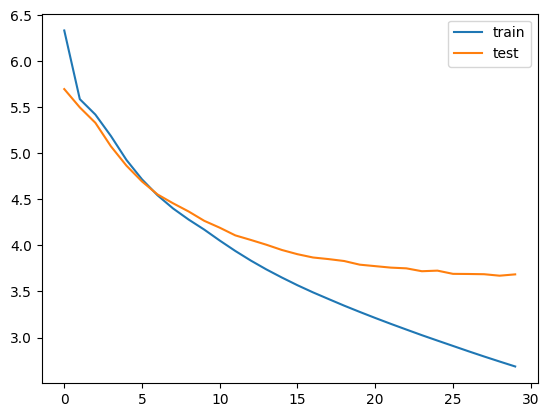

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# 저장된 가중치 로드
model.load_weights('best_transformer_weights.weights.h5')

### 실제 결과와 요약문 비교하기(추상적 요약)

In [53]:
# 주요 변수 확인 및 매핑
src_index_to_word = src_tokenizer.index_word  # 원문 단어 집합에서 정수 -> 단어
tar_word_to_index = tar_tokenizer.word_index  # 요약 단어 집합에서 단어 -> 정수
tar_index_to_word = tar_tokenizer.index_word  # 요약 단어 집합에서 정수 -> 단어

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LayerNormalization, Add, Lambda

# 레퍼런스 인코더 입력과 출력
encoder_inputs = model.input[0]  # encoder_inputs
encoder_outputs = model.get_layer(name="encoder_layer_3").output  # 최종 출력 인코더

# 인코더 모델
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_outputs)

# 디코더 입력 정의
decoder_inputs = Input(shape=(1,), name="decoder_inputs_test")  # decoder_inputs_test
encoder_outputs_input = Input(shape=(50, 128), name="encoder_outputs_test")  # 받아올 인코더 출력

# 디코더 임베딩 & 포지셔널 임베딩
decoder_embedding_layer = model.get_layer(name="decoder_embedding")  # 디코더 임베딩
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_pos_encoding = positional_encoding(1, 128)  # 포지셔널 인코딩
decoder_outputs = decoder_embedding + decoder_pos_encoding

# Look-Ahead Mask와 Padding Mask 생성 (Lambda를 사용하여 처리)
look_ahead_mask = Lambda(lambda _: create_look_ahead_mask(1), name="look_ahead_mask_test")(decoder_inputs)
padding_mask = Lambda(lambda seq: create_padding_mask(seq), name="padding_mask_test")(decoder_inputs)
combined_mask = Lambda(lambda masks: tf.maximum(masks[0], masks[1]), name="combined_mask_test")([look_ahead_mask, padding_mask])

# 디코더 레이어
for i in range(4):  # 총 4개
    decoder_layer = model.get_layer(name=f"decoder_layer_{i}")  # 디코더
    mha_layer = model.get_layer(name=f"decoder_attention_{i}")  # 멀티헤드 어텐션

    # 디코더의 Self-Attention에 마스킹 추가
    decoder_outputs = decoder_layer(decoder_outputs, mask=combined_mask)

    # 멀티헤드 어텐션 (쿼리=디코더 출력, 키/값=인코더 출력)
    attention_output = mha_layer(
        q=decoder_outputs,
        k=encoder_outputs_input,
        v=encoder_outputs_input
    )

    # Add & Normalize
    decoder_outputs = Add(name=f"decoder_add_attention_{i}_test")([decoder_outputs, attention_output])
    decoder_outputs = LayerNormalization(epsilon=1e-6, name=f"decoder_layer_norm_{i}_test")(decoder_outputs)

# 최종 Dense
final_output = model.get_layer(name="final_dense")(decoder_outputs)

# 디코더 모델
decoder_model = Model(inputs=[decoder_inputs, encoder_outputs_input], outputs=final_output)

In [54]:
def decode_sequence(input_seq, return_tokens=False, temperature=1.0, top_k=5, top_p=0.9):
    """
    입력 문장(input_seq)을 받아 인코더와 디코더를 통해 요약문 생성
    """
    # 1. 인코더를 통해 입력 문장의 출력 생성
    encoder_output = encoder_model.predict(input_seq)

    # 2. 디코더의 시작 토큰을 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']  # 시작 토큰

    # 3. 디코더를 반복적으로 호출하여 요약문 생성
    stop_condition = False
    decoded_sentence = []
    decoded_tokens = []

    while not stop_condition:
        # 디코더를 호출하여 출력 생성
        output_tokens = decoder_model.predict([target_seq, encoder_output])

        # 다음 단어의 확률 분포
        preds = output_tokens[0, -1, :]

        # Temperature Sampling 적용
        if temperature and temperature != 1.0:
            sampled_token_index = temperature_sampling(preds, temperature)
        # Top-k Sampling 적용
        elif top_k:
            sampled_token_index = top_k_sampling(preds, k=top_k)
        # Top-p Sampling 적용
        elif top_p:
            sampled_token_index = top_p_sampling(preds, p=top_p)
        else:
            # 기본적으로는 argmax 사용
            sampled_token_index = np.argmax(preds)

        decoded_tokens.append(sampled_token_index)

        # 종료 조건 확인
        if (sampled_token_index == tar_word_to_index['eostoken'] or
                len(decoded_sentence) >= (summary_max_len - 1)):
            stop_condition = True
        else:
            # 인덱스를 단어로 변환하여 문장에 추가
            sampled_token = tar_index_to_word.get(sampled_token_index, '<UNK>')
            decoded_sentence.append(sampled_token)

        # 디코더 입력 갱신
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    if return_tokens:
        return decoded_tokens
    return ' '.join(decoded_sentence).strip()

In [55]:
def seq2text(input_seq):
    return ' '.join([src_index_to_word.get(i, '<UNK>') for i in input_seq if i != 0])

def seq2summary(input_seq):
    return ' '.join([
        tar_index_to_word.get(i, '<UNK>')
        for i in input_seq
        if i != 0 and i not in {tar_word_to_index['sostoken'], tar_word_to_index['eostoken']}
    ])

## **12장에서 배운 아래 3가지 규제 및 조건을 통해 반복적인 값이 도출되는 빈도를 줄이고 추출해봤다**

### Temperature Sampling
* 단어 선택 확률 분포의 무작위성을 추가

### Top-k Sampling
* 모델이 예측한 확률 분포 상에서 상위 k개에서 후보 중 단어 선택. 임의성을 낮추고 품질을 유지하는 것이 목표

### Top-p Sampling
*  누적 확률의 합이 p 이상이 되기 전까지 상위의 단어들을 포함시키고 해당 집합에서 단어 선택

In [56]:
for i in range(14):
    print(f"원문 ({i}):", seq2text(encoder_input_test[i]))
    print(f"실제 요약 ({i}):", seq2summary(decoder_target_test[i]))
    print(f"예측 요약 ({i}):", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 (0): delhi high court sent notice centre army chief seeking response petition alleging three castes <UNK> rajputs jat sikhs considered recruitment president bodyguard petitioner said belonged ahir yadav caste fulfilled criteria eligibility except caste sought recruitment post
실제 요약 (0): hc notice to govt on caste based recruitment of prez bodyguard
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
예측 요약 (0): hc notice to pil issued plea warrants hc asks sc notice


원문 (1): <UNK> tree believed planted years ago wales fallen <UNK> tree located along <UN

## **아래는 무작위 샘플링을 진행하지 않았을 때, text와 headlines 실제 예측 요약 비교문이다**



# ..뭐든 시도에 의의가 있는 법이다.

* 실제 요약 (0): who is <UNK> goyal the jee advanced topper
* 예측 요약 (0): haryana tops jee topper jee topper jee topper jee topper jee
------
* 실제 요약 (1): defends rafale deal in wedding card pm modi writes to them
* 예측 요약 (1): pmo asks yes pm modi gifts gifts gifts gifts gifts gifts
------
* 실제 요약 (2): <UNK> still totally correct for china president jinping
* 예측 요약 (2): pranab mukherjee should pray pranab mukherjee should pray pranab mukherjee should
------
* 실제 요약 (3): porsche unveils the new <UNK> suv with self driving features
* 예측 요약 (3): porsche develops lamborghini porsche develops lamborghini porsche develops lamborghini porsche develops
------
* 실제 요약 (4): those who criticised me <UNK> own spit now sidhu on kartarpur
* 예측 요약 (4): imran khan belongs did not afraid of pak polls impossible kl
------
* 실제 요약 (5): russian prez putin limits cash transfers to ukraine
* 예측 요약 (5): putin russia putin russia putin russia putin russia putin russia putin
------
* 실제 요약 (6): google slammed by court over users right to be forgotten
* 예측 요약 (6): uber suspends uber suspends uber suspends uber suspends uber suspends uber
------
* 실제 요약 (7): nehwal loses to world no finishes runner up at denmark open
* 예측 요약 (7): saina nehwal nehwal nehwal nehwal nehwal nehwal nehwal nehwal nehwal nehwal
------
* 실제 요약 (8): teen kills yr old for <UNK> tractor paint in punjab
* 예측 요약 (8): yr old boy dies after yr old boy dies after yr
------
* 실제 요약 (9): would be worst <UNK> if we celebrate like kohli aus coach
* 예측 요약 (9): kohli paine paine paine paine paine paine paine paine paine paine
------
* 실제 요약 (10): former high court judge cs karnan forms political party
* 예측 요약 (10): karnan grants justice karnan grants justice karnan grants justice karnan grants

## 그래도 핵심 토큰은 잘 집어넣긴 했다. 문법적오류 및 중복이 많아서 그렇지
 * 디코더에서 중요 문장에 집중도를 제한하거나 아니면 아예 단어 수에 제한 걸어버리면 그나마 깔끔할 것 같다.
 * 중복 단어가 뒤에 쭉 이어지는데, 내 생각엔 중요도가 높다고 판단한 단어를 계속 내뱉는 경향이 있는 것 같다.
 * 아니면, 패딩 쪽 마스킹을 잘 못해서 학습에 영향을 줬나 싶기도 하다.

### Summa을 이용해서 추출적 요약해보기

In [ ]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=8f834fbece364d83046b5652718824340b14d5a16149dc624e673d62035b70bc
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [ ]:
data.head()

,headlines,text,decoder_input,decoder_target,decoder_conbined
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...


In [ ]:
import summa
from summa import summarizer
from summa.summarizer import summarize
print(version('summa'))

1.2.0


In [ ]:
data['text'][1111]

'traders body cait urged commerce minister suresh prabhu probe amazon samara capital acquisition billionaire kumar mangalam birla supermarket chain cait claims deal circumvents revised fdi policy commerce wants stay deal till probe conducted comes cci approved acquisition friday'

In [ ]:
# 각 행별 문자열 길이 계산
data['text_length'] = data['text'].apply(len)

# 길이를 기준으로 상위 10개 정렬
top_10_rows = data.nlargest(20, 'text_length')

# 결과 출력
print(top_10_rows[['text', 'text_length']])

                                                    text  text_length
12302  drive next generation experiencechange says br...          370
11094  british bank hsbc executed india first oversea...          365
15892  bajaj allianz life launched critical illness p...          360
19959  several guests suffered uncontrollable diarrho...          360
379    maharashtra navnirman sena president raj thack...          358
428    nissan kicks recently launched india equipped ...          355
83623  us president donald trump russian president vl...          352
29238  allen solly india pioneer brand unconventional...          351
12971  dussehra reliance general insurance urges peop...          348
75187  prime minister narendra modi thanked world lea...          347
6987   maharashtra electricity regulator formed two m...          346
9224   chennai based iot startup detect technologies ...          346
10277  volkswagen recently launched volkswagen connec...          346
21644  automaker her

In [ ]:
# 첫번째행
text_to_summarize = data['text'][379]
summary = summarizer.summarize(text_to_summarize, ratio=0.3,words=10)

# 요약이 비어있음?
if summary:
    print("headlines:")
    print(summary)
else:
    print("요약없음")

요약없음


### 요약하려는 문장이 너무 짧다. 아래 정도는 되어야 요약이 잘 일어나는데.

In [ ]:
# 첫번째행만
text_to_summarize = 'In many Western countries, a question you should never ask in the first encounter with someone is his or her age. Among many Koreans, however, asking such sensitive personal information is a common way to start a conversation. Identifying a person’s age is a must-do process. Although I found it to be quite rude or sometimes offensive at first, I soon realized the logic behind it : to respect the elders and to classify the person. In the Western world, age is considered by many to be only a number. Many Westerners believe each person has a different way of life andage should not be considered as a major factor for doing what he or she desires in life. Many Westerners tend to judge you by your behavior before they know how old you are. In Korea, it is exactly the opposite. Koreans want to know your age first, and then what kind of person you are. It seems a person’s age is the most single important factor when judging a person. By conservative Korean tradition, you must pay unconditional respect by using respectful words to a person older than you. As a Korean who was raised in England, I personally think it is a great Confucian tradition to show respect to someone, especially for elders. However, a false stereotype and negative media portrayal have implanted a wrong social value and public perception toward age in Korean society today. In England, I went to school with people of various nationalities, backgrounds, cultures and ages. I especially learned so much from mature students in their 30s and 40s. They had so much to offer and I was always intrigued by their life experience and wisdom. I wish Korean colleges and universities opened up for more mature students. Younger people need to be exposed more to people from various walks of life. They need to understand that aging is not simply a process of becoming old and age should not be a barrier in starting a friendship. Maturity and wisdom also go with it. The same goes for the elders too Elders need to understand that respect should be earned not given. Instead of only correcting the misbehavior of youngsters, elders need to understand and to talk with youngsters to narrow the gap. Trying to become a friend with them is of the utmost importance.'
# 요약
summary = summarizer.summarize(text_to_summarize, ratio=0.4,words=50)

# 요약이 비어있음?
if summary:
    print("headlines:")
    print(summary)
else:
    print("요약없음")

headlines:
Koreans want to know your age first, and then what kind of person you are.
It seems a person’s age is the most single important factor when judging a person.
As a Korean who was raised in England, I personally think it is a great Confucian tradition to show respect to someone, especially for elders.


### 표를 만들기는 힘들 것 같고 1개만 비교해보자.
#### 우연하게 LSM환경에서 얻어걸린 조합이 있다. 버전 문제인지 동일한 조건인데 코랩에서는 안된다.

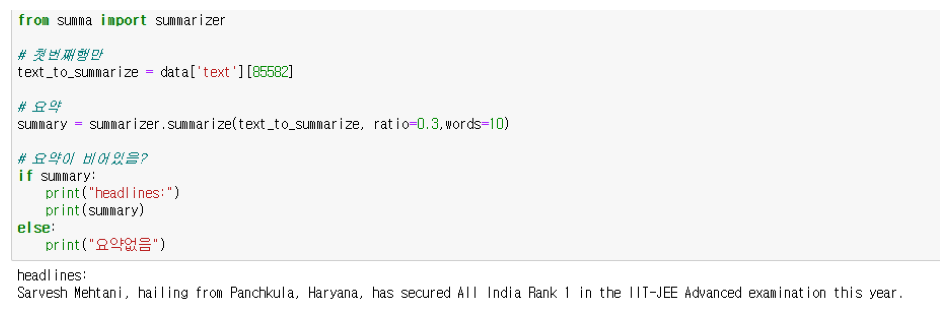

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = '/content/drive/MyDrive/aiffel/Data/lms.png'

# 이미지 불러오기
image = Image.open(image_path)

# 확대하여 이미지 표시
plt.figure(figsize=(12, 12))  # figsize로 크기 조정 (여기서 숫자를 더 크게 조정 가능)
plt.imshow(image)
plt.axis('off')  # 축 숨기기
plt.show()

#### 아래는 셔플된 데이터에서 트랜스포머로 추상한 첫번째 원문 요약이다
#### 샘플링 전략을 적용하지 않았을 때
* 실제 요약 : who is <UNK> goyal the jee advanced topper
* 추상적 예측 요약 : haryana tops jee topper jee topper jee topper jee topper jee
* 추출적 예측 요약 : Sarvesh Mehtani, hailing from Panchkula, Haryana, has secured All India Rank 1 in the IIT-JEE Advanced examination this year.

* 추상적 요약은 topper와 jee를 추정해냈다.
* 반면에 추출적 요약은 굉장히 세부적인 내용에 국한되어 있는듯 싶다.

In [61]:
data[data['text'].str.contains("rajputs", case=False, na=False)].index

Index([ 4587,  8787,  9076,  9106, 11961, 30256, 33491, 38432, 50656, 50670,
       50694, 50931, 60119, 60788, 61992],
      dtype='int64')

In [58]:
data[data['text'].str.contains("bodyguard", case=False, na=False)].index

Index([ 4587,  6763,  8733,  9211, 13008, 14924, 15573, 17533, 19209, 22477,
       22941, 22971, 25975, 27484, 27487, 28534, 28581, 30542, 31126, 32952,
       33608, 33928, 36303, 38685, 38849, 40241, 42066, 43587, 52294, 52490,
       56294, 56794, 56939, 60753, 61705, 63131, 64841, 72614, 73543, 74971,
       76382, 79682, 87844, 88199, 88621, 89107, 89643, 91349, 92975, 93165,
       97382, 97459, 98217],
      dtype='int64')

In [ ]:
# 셔플된 후의 0번 원문은 기존 데이터에서 4587 인덱스
# 추출적 예측 요약은 역시나 코랩에서 안되기에 lms 상에서 긁어왔다.

### 샘플링 전략을 추가한 뒤 비교

* 원문 (0): delhi high court sent notice centre army chief seeking response petition alleging three castes <UNK> rajputs jat sikhs considered recruitment president bodyguard petitioner said belonged ahir yadav caste fulfilled criteria eligibility except caste sought recruitment post
---
* 실제 요약 (0): hc notice to govt on caste based recruitment of prez bodyguard
---
* 추상적 예측 요약 (0): hc notice to pil issued plea warrants hc asks sc notice
---
* 추출적 예측 요약 : The Delhi High Court has sent a notice to Centre and Army chief, seeking their response to a petition alleging that only three castesÃ¢ÂÂ Jats, Rajputs and Jat SikhsÃ¢ÂÂ are considered for recruitment of President's Bodyguard.



## 확실히 샘플링 전략을 적용해야 뭔가 엇비슷해보이기라도 하는 것 같다.
* 추출적 요약은 원문이 짧다보니 단어를 길게 주면 전부 내뱉고 단어를 짧게 주면 요약을 못한다.